# MD Anderson Tumor Supervised Subtyping: sc53


In [1]:
import scvelo as scv
import scanpy as sc
import os.path as op
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import mazebox as mb

In [2]:
# !pip install phate

## Read in Files

In [21]:

#############################################################
# Read in loom files
# loom files were created as described in manuscript by velocyto pipeline
#############################################################

indir = "/Users/smgroves/Box/Byers-Quaranta-Collab/Gay et al. (2021)/code"

#untreated SC53 sample
sample1 = 'SC53.LB19005_GT19_09245_SI-GA-B3_S21_L001'
rep1 = scv.read(f'{indir}/SC53/{sample1}.loom', cache=True)
rep1.var_names_make_unique()

#treated SC53 sample
sample2 = 'SC53cis.LB19006_GT19_34513_SI-GA-B1_S2_L001'
rep2 = scv.read(f'{indir}/SC53/{sample2}.loom', cache=True)
rep2.var_names_make_unique()

#concatenate datasets together
adata_full = rep1.concatenate(rep2, batch_key = 'treatment',batch_categories=['untreated', 'cisplatin'])

/Users/smgroves/Documents/anaconda3/envs/emt_sclc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/smgroves/Documents/anaconda3/envs/emt_sclc_env/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(
/Users/smgroves/Documents/anaconda3/envs/emt_sclc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/smgroves/Docum

In [22]:
adata_full

AnnData object with n_obs × n_vars = 161393 × 43306
    obs: 'treatment'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [23]:
#############################################################
# Filter cells to be consistent with rest of manuscript
#############################################################

#use only filtered cells from previous analyses (barcodes listed in each csv below)
unt_names = pd.read_csv(f'{indir}/SC53/53_unt_filtered_cells.csv', header = 0, index_col=0)
unt_filtered = []
for i in unt_names['x']:
    n = i.split('.')[1].split('-')[0]
    unt_filtered.append(n)

cis_names = pd.read_csv(f'{indir}/SC53/53_cis_filtered_cells.csv', header = 0, index_col=0)
cis_filtered = []
for i in cis_names['x']:
    n = i.split('.')[1].split('-')[0]
    cis_filtered.append(n)

#generate filtered dataframe based on two csvs above
filter_obs = pd.DataFrame(index=adata_full.obs_names, columns=['filter', 'treatment'])
for i in adata_full[adata_full.obs['treatment']=='untreated'].obs_names:
    n = i.split('/')[9]
    s = (n.split('_')[5].split(':')[1].split('-')[0])
    filter_obs.loc[i]['filter'] =s
    filter_obs.loc[i]['treatment'] ='untreated'

for i in adata_full[adata_full.obs['treatment']=='cisplatin'].obs_names:
    n = i.split('/')[9]
    s = (n.split('_')[5].split(':')[1].split('-')[0])
    filter_obs.loc[i]['filter'] =s
    filter_obs.loc[i]['treatment'] ='cisplatin'

# finally, set "filtered" attribute of adata_full
unt_bool = []
for i,r in filter_obs.iterrows():
    if r['treatment'] == 'cisplatin':
        if r['filter'] in cis_filtered:
            unt_bool.append('True-cis')
        else: unt_bool.append(None)

    elif r['treatment'] == 'untreated':
        if r['filter'] in unt_filtered:
            unt_bool.append('True-unt')
        else: unt_bool.append(None)
filter_obs['kept'] = unt_bool

adata_full.obs['filtered'] = filter_obs['kept']





Normalizing...
Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:06) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


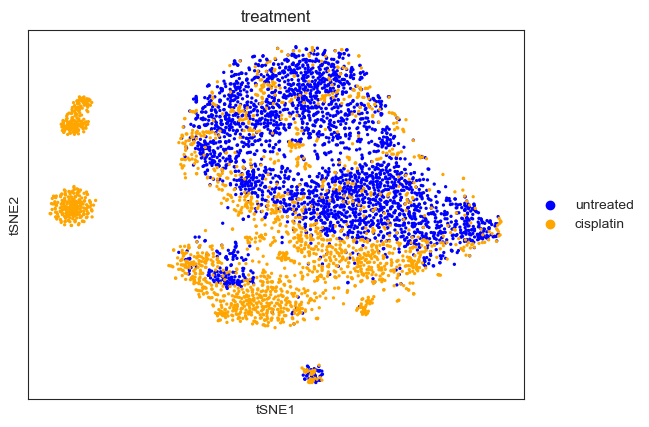

In [24]:
adata = adata_full[(adata_full.obs.filtered=='True-cis') | (adata_full.obs.filtered=='True-unt') ,:].copy()
print("Normalizing...")
sc.pp.normalize_per_cell(adata, copy=False)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 5, min_disp = 0.8)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
scv.pp.moments(adata)
sc.tl.tsne(adata)
sc.tl.leiden(adata)
sc.pl.tsne(adata, color = ['treatment'], palette = ['blue','orange'])

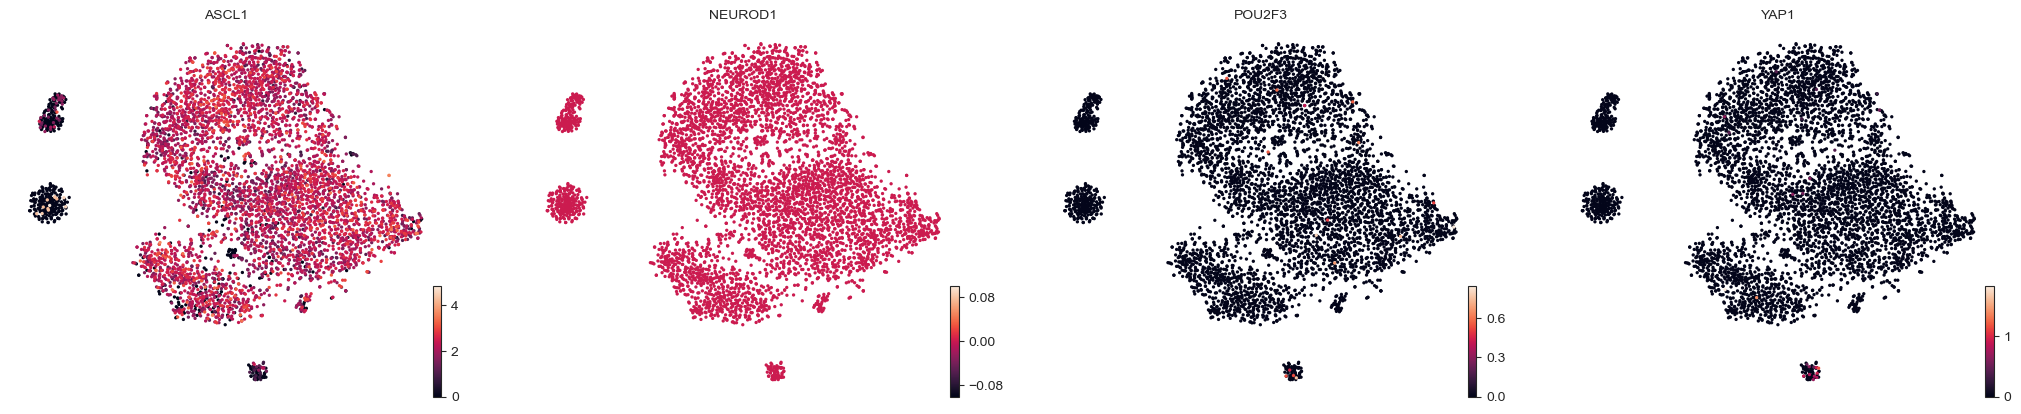

In [25]:
scv.pl.tsne(adata, color = ['ASCL1','NEUROD1','POU2F3', "YAP1"], legend_loc = 'on data')

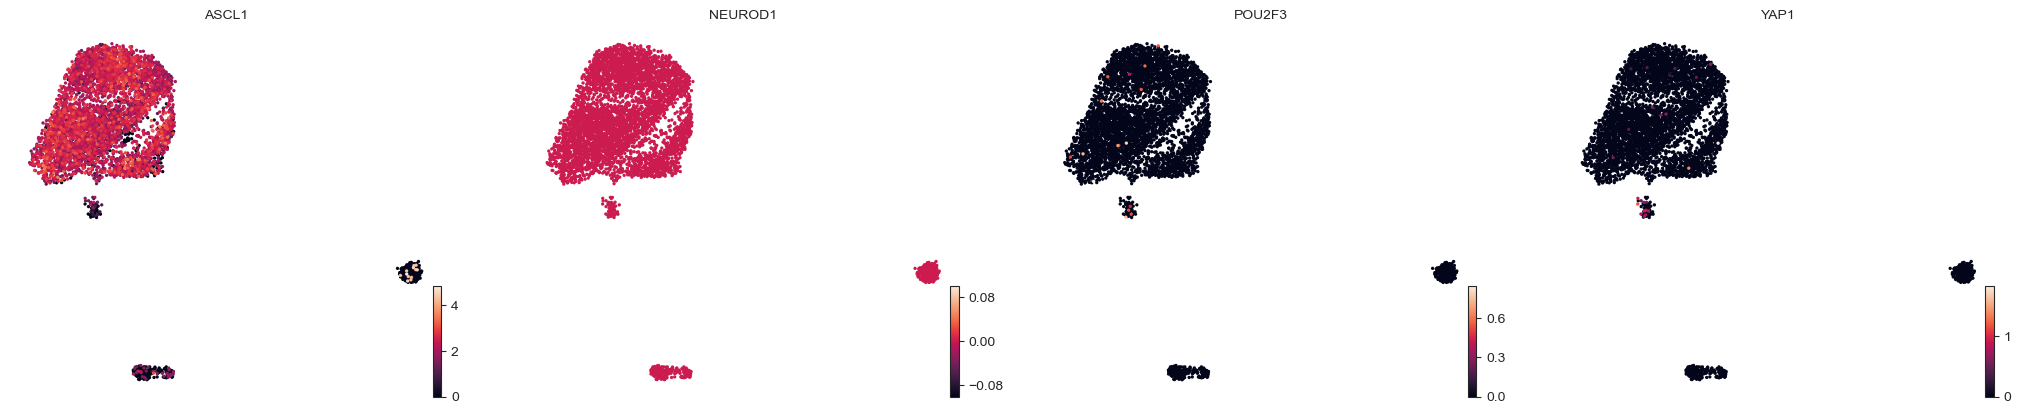

In [26]:
sc.tl.umap(adata)

scv.pl.umap(adata, color = ['ASCL1','NEUROD1','POU2F3', "YAP1"], legend_loc = 'on data')

## Archetype supervised subtyping

In [27]:
# sig_matrix copied from Groves_CellSys2021/notebooks/out/bulk/sig_matrix_ParTI_2021.csv
sig_matrix = pd.read_csv('../sig_matrix_ParTI_2021.csv', header =0, index_col = 0)

sig_matrix = sig_matrix / np.linalg.norm(sig_matrix, axis=0)
sig_matrix.index = [i.upper() for i in sig_matrix.index]

Notice below that all 105 genes from the matrix are in the data.

Transforming tumor data...
Gene signature matrix now has shape:  (105, 5)
Tumor data shortened to genes in gene list...


/Users/smgroves/Documents/anaconda3/envs/emt_sclc_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


(5202, 105)
Tumor data subsetting complete.


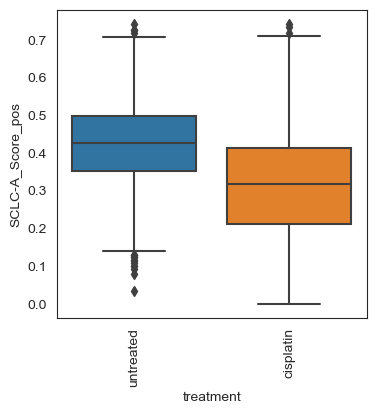

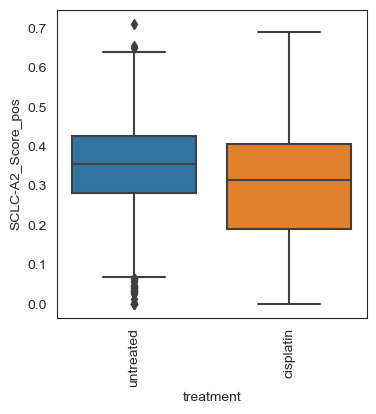

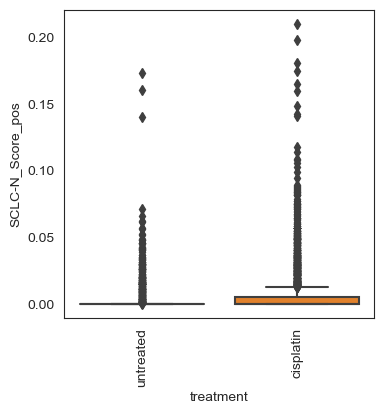

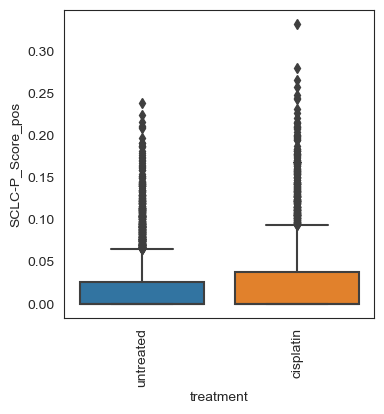

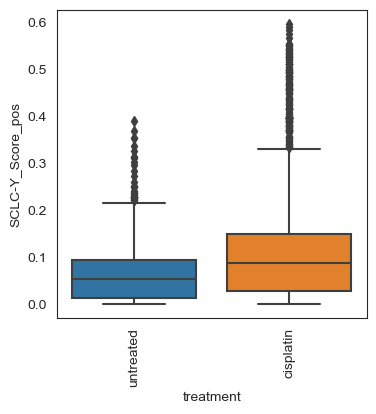

In [28]:
adata, adata_small, sig_matrix2 = mb.ar.phenotyping_recipe(adata, sig_matrix, groupby = 'treatment',velocity=False, save='figures/', type = "csr", save_as = "")


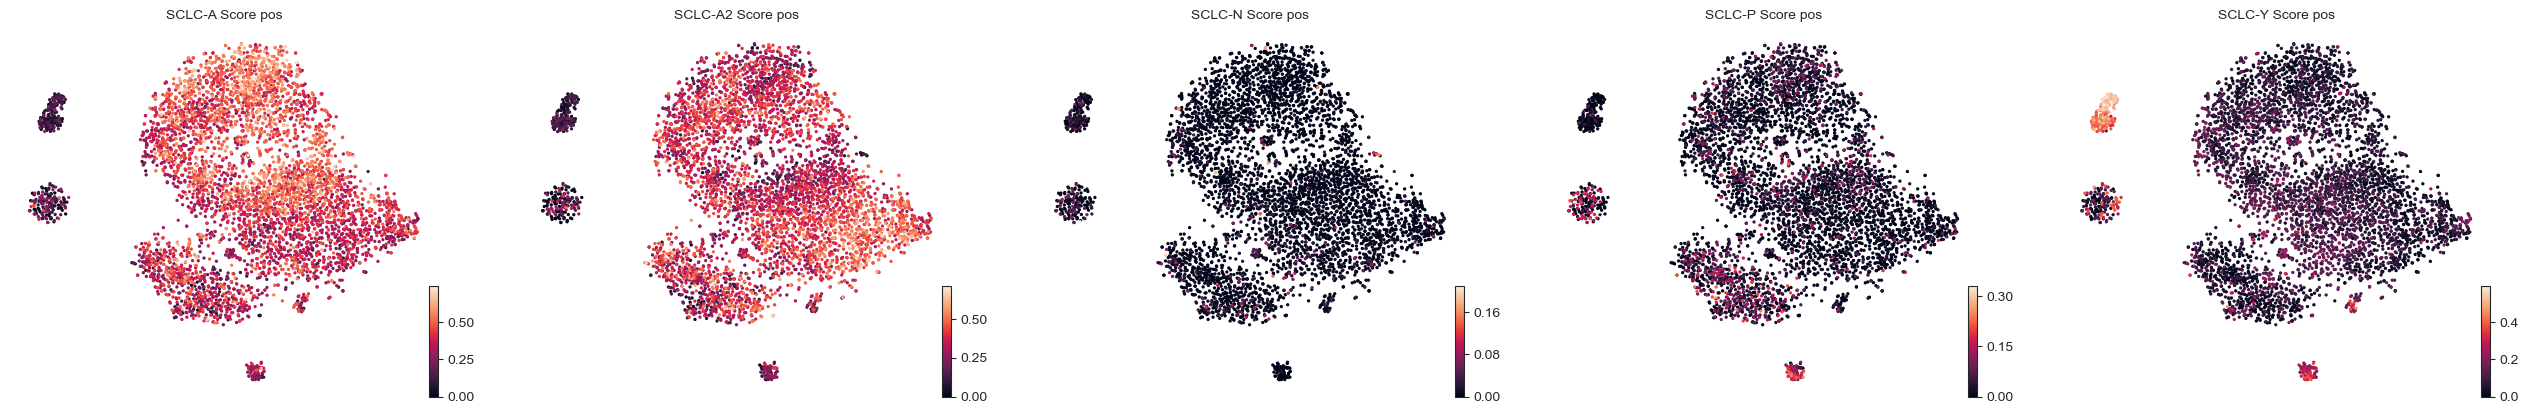

In [29]:
scv.pl.tsne(adata, color = ['SCLC-A_Score_pos','SCLC-A2_Score_pos', 'SCLC-N_Score_pos','SCLC-P_Score_pos', 'SCLC-Y_Score_pos'], legend_loc = 'on data')

In [30]:
adata.obs[[x for x in adata.obs.columns if x.endswith('Score_pos')]].to_csv('./out/MDA_SC53_supervised_archetype_scores.csv')

In [33]:
adata.write_h5ad("./out/SC53.h5ad")

# MD Anderson Tumor Supervised Subtyping: SC68


## Read in Files

In [6]:

#############################################################
# Read in loom files
# loom files were created as described in manuscript by velocyto pipeline
#############################################################
indir = "/Users/smgroves/Box/Byers-Quaranta-Collab/Gay et al. (2021)/code"

#untreated sc68 sample
sample1 = 'SC68.LB19002_GT19-03882_SI-GA-C4_S7_L007'
rep1 = scv.read(f'{indir}/SC68/{sample1}.loom', cache=True)
rep1.var_names_make_unique()

sample2 = 'SC68cr.LB19003_GT19-05072_S1_L001'
rep2 = scv.read(f'{indir}/SC68/{sample2}.loom', cache=True)
rep2.var_names_make_unique()

#concatenate datasets together
adata_full = rep1.concatenate(rep2, batch_key = 'treatment',batch_categories=['untreated', 'cisplatin'])


/Users/smgroves/Documents/anaconda3/envs/emt_sclc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/smgroves/Documents/anaconda3/envs/emt_sclc_env/lib/python3.9/site-packages/anndata/utils.py:111: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-4', 'SNORD116-5']
  warnings.warn(
/Users/smgroves/Documents/anaconda3/envs/emt_sclc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/smgroves/Docum

In [7]:
adata_full

AnnData object with n_obs × n_vars = 39002 × 43306
    obs: 'treatment'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [8]:

#############################################################
# Filter cells to be consistent with rest of manuscript
#############################################################

#use only filtered cells from previous analyses (barcodes listed in each csv below)
unt_names = pd.read_csv(f'{indir}/sc68/68_unt_filtered_cells.csv', header = 0, index_col=0)
unt_filtered = []
for i in unt_names['x']:
    n = i.split('.')[2].split('-')[0]
    unt_filtered.append(n)

cis_names = pd.read_csv(f'{indir}/sc68/68_cis_filtered_cells.csv', header = 0, index_col=0)
cis_filtered = []
for i in cis_names['x']:
    n = i.split('.')[2].split('-')[0]
    cis_filtered.append(n)


In [9]:

#generate filtered dataframe based on two csvs above
filter_obs = pd.DataFrame(index=adata_full.obs_names, columns=['filter', 'treatment'])
for i in adata_full[adata_full.obs['treatment']=='untreated'].obs_names:
    n = i.split('/')[6]
    s = (n.split('_')[4].split(':')[1].split('-')[0])
    filter_obs.loc[i]['filter'] =s
    filter_obs.loc[i]['treatment'] ='untreated'

for i in adata_full[adata_full.obs['treatment']=='cisplatin'].obs_names:
    n = i.split('/')[6]
    s = (n.split('_')[3].split(':')[1].split('-')[0])
    filter_obs.loc[i]['filter'] =s
    filter_obs.loc[i]['treatment'] ='cisplatin'

# finally, set "filtered" attribute of adata_full
unt_bool = []
for i,r in filter_obs.iterrows():
    if r['treatment'] == 'cisplatin':
        if r['filter'] in cis_filtered:
            unt_bool.append('True-cis')
        else: unt_bool.append(None)

    elif r['treatment'] == 'untreated':
        if r['filter'] in unt_filtered:
            unt_bool.append('True-unt')
        else: unt_bool.append(None)
filter_obs['kept'] = unt_bool

adata_full.obs['filtered'] = filter_obs['kept']


In [10]:
adata = adata_full[(adata_full.obs.filtered=='True-cis') | (adata_full.obs.filtered=='True-unt') ,:].copy()
adata

AnnData object with n_obs × n_vars = 4955 × 43306
    obs: 'treatment', 'filtered'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

Normalizing...
Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:05) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


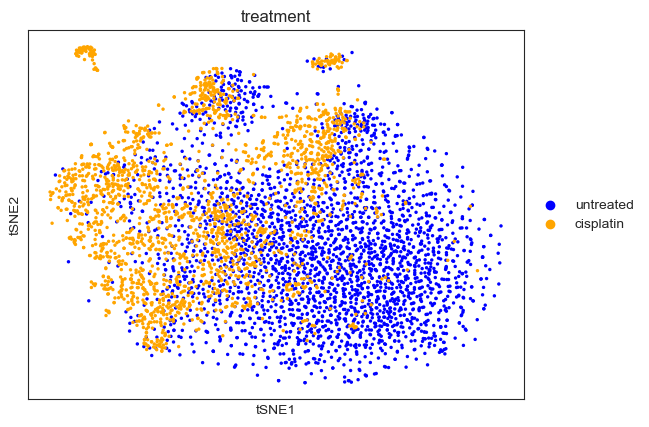

In [11]:
print("Normalizing...")
sc.pp.normalize_per_cell(adata, copy=False)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 5, min_disp = 0.8)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
scv.pp.moments(adata)
sc.tl.tsne(adata)
sc.tl.leiden(adata)
sc.pl.tsne(adata, color = ['treatment'], palette = ['blue','orange'])


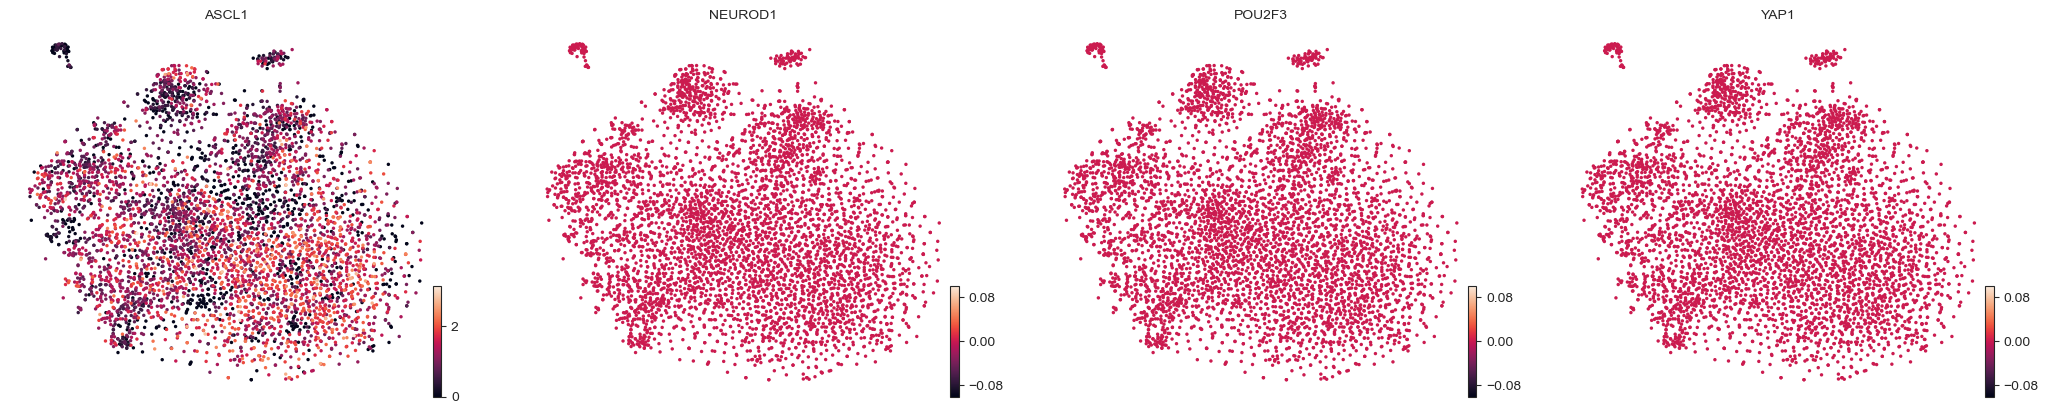

In [12]:
scv.pl.tsne(adata, color = ['ASCL1','NEUROD1','POU2F3', "YAP1"], legend_loc = 'on data')

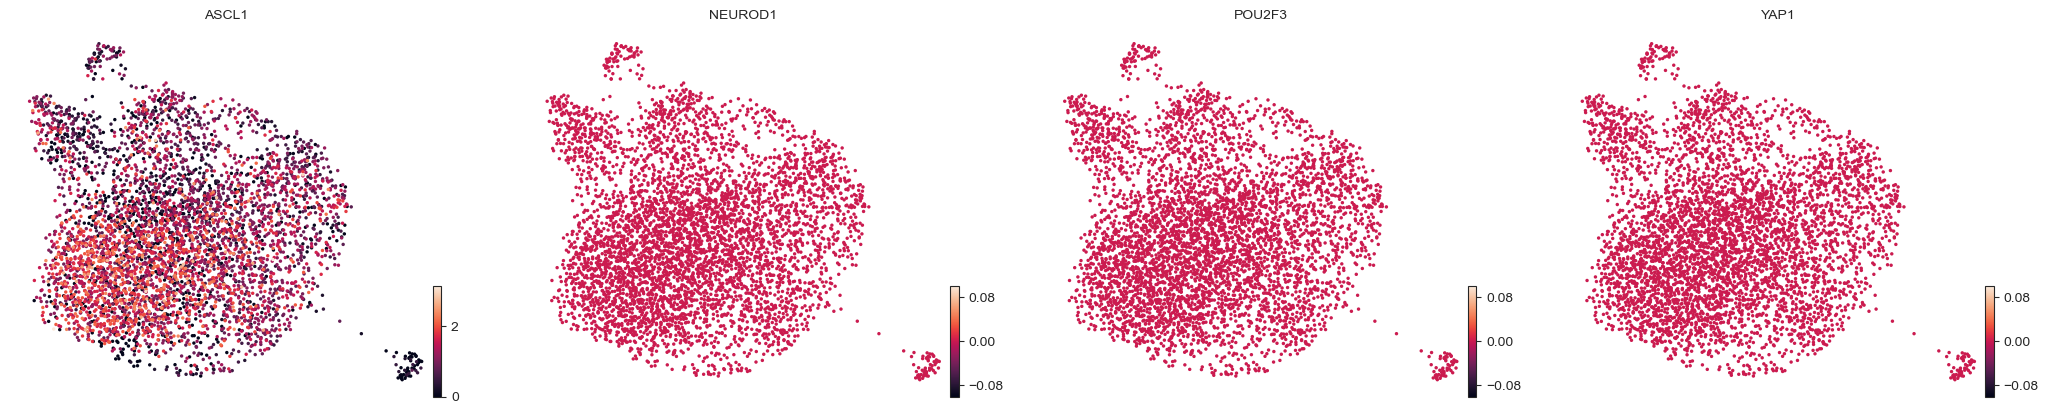

In [13]:
sc.tl.umap(adata)

scv.pl.umap(adata, color = ['ASCL1','NEUROD1','POU2F3', "YAP1"], legend_loc = 'on data')

## Archetype supervised subtyping

In [14]:
# sig_matrix copied from Groves_CellSys2021/notebooks/out/bulk/sig_matrix_ParTI_2021.csv
sig_matrix = pd.read_csv('../sig_matrix_ParTI_2021.csv', header =0, index_col = 0)

sig_matrix = sig_matrix / np.linalg.norm(sig_matrix, axis=0)
sig_matrix.index = [i.upper() for i in sig_matrix.index]

Notice below that all 105 genes from the matrix are in the data.

Transforming tumor data...
Gene signature matrix now has shape:  (105, 5)
Tumor data shortened to genes in gene list...


/Users/smgroves/Documents/anaconda3/envs/emt_sclc_env/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


(4931, 105)
Tumor data subsetting complete.


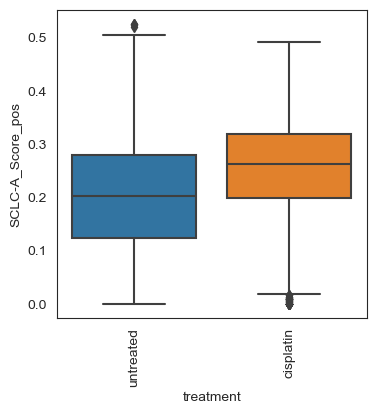

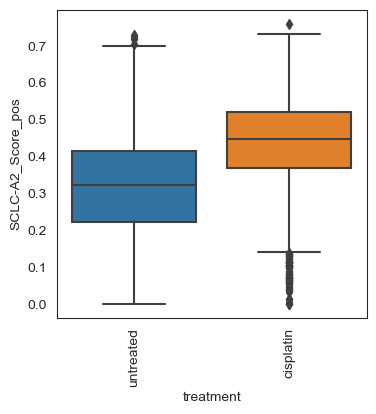

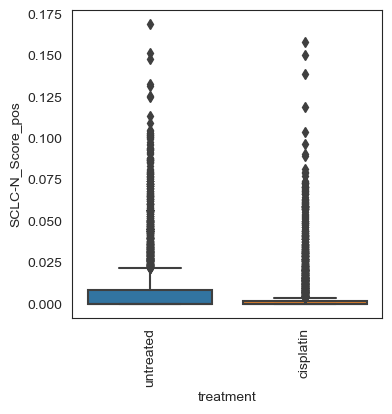

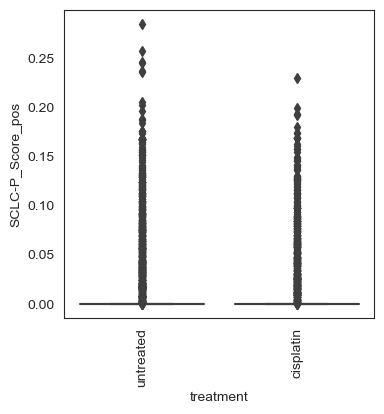

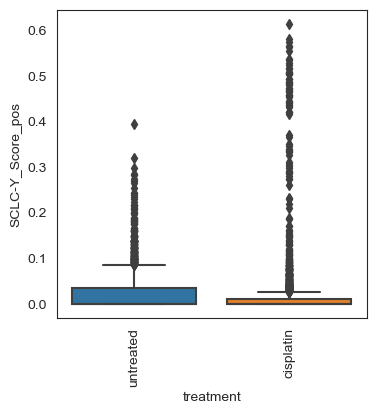

In [15]:
adata, adata_small, sig_matrix2 = mb.ar.phenotyping_recipe(adata, sig_matrix, groupby = 'treatment',velocity=False, save='figures/', type = "csr", save_as = "")


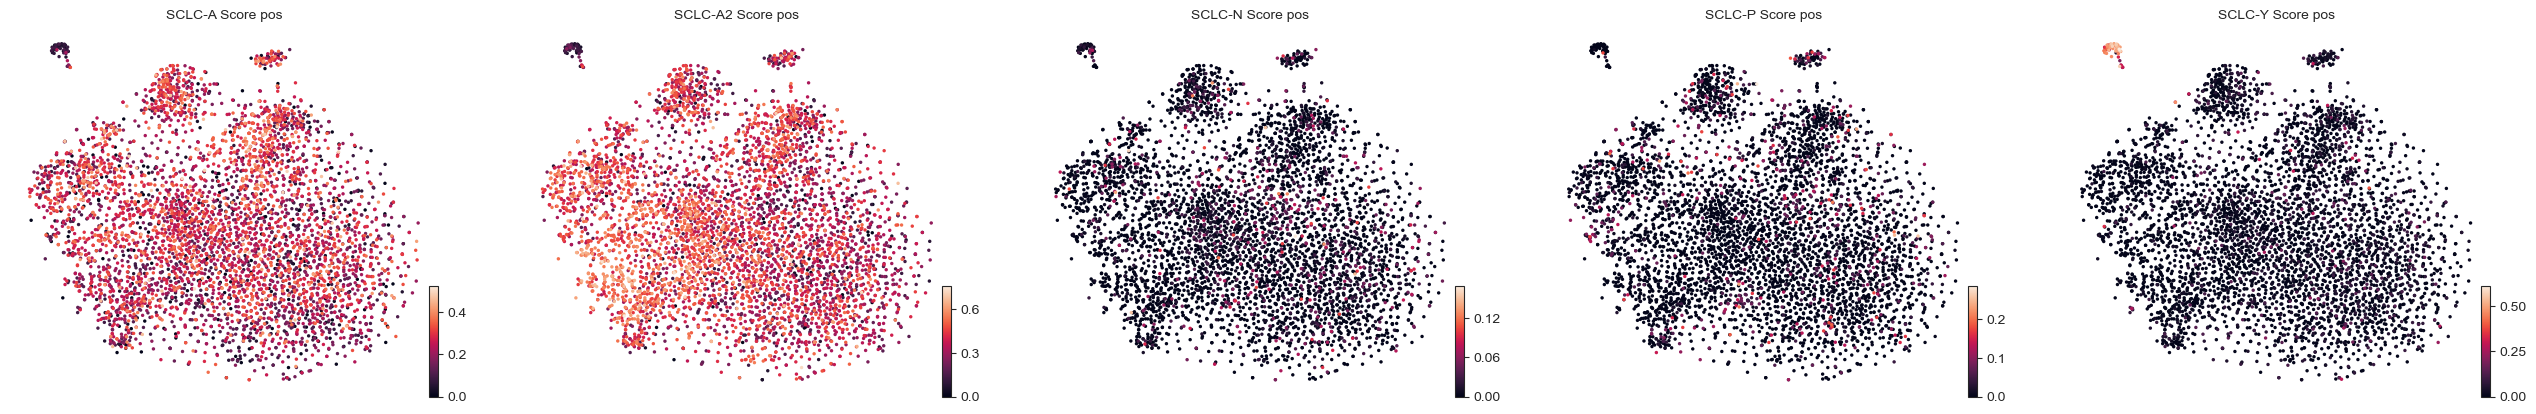

In [16]:
scv.pl.tsne(adata, color = ['SCLC-A_Score_pos','SCLC-A2_Score_pos', 'SCLC-N_Score_pos','SCLC-P_Score_pos', 'SCLC-Y_Score_pos'], legend_loc = 'on data')

In [17]:
adata.obs[[x for x in adata.obs.columns if x.endswith('Score_pos')]].to_csv('./out/MDA_SC53_supervised_archetype_scores.csv')

In [18]:
adata.write_h5ad("./out/SC68.h5ad")

In [19]:
adata = sc.read_h5ad("./out/SC68.h5ad")

In [20]:
adata

AnnData object with n_obs × n_vars = 4955 × 43306
    obs: 'treatment', 'filtered', 'n_counts', 'leiden', 'SCLC-Y_Score', 'SCLC-P_Score', 'SCLC-N_Score', 'SCLC-A2_Score', 'SCLC-A_Score', 'Phenotype', 'SCLC-A_Score_pos', 'SCLC-A2_Score_pos', 'SCLC-N_Score_pos', 'SCLC-P_Score_pos', 'SCLC-Y_Score_pos'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'treatment_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

# H5AD files directly from Gay et al. manuscript

In [79]:
sc53 = sc.read_h5ad("/Users/smgroves/Dropbox (VU Basic Sciences)/Quaranta_Lab/SCLC/scRNAseq-analysis/single-cell-subtyping/subtyping_methods/code/byers_cdx/adata_mda_sc53.h5ad")

In [80]:
sc53

AnnData object with n_obs × n_vars = 5268 × 22260
    obs: 'treatment', 'n_genes', 'n_counts', 'percent_mito', 'filtered', 'leiden', 'velocity_self_transition', 'S_score', 'G2M_score', 'phase', 'clusters_gradients', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma_untreated', 'velocity_r2_untreated', 'velocity_genes_untreated', 'velocity_gamma_cisplatin', 'velocity_r2_cisplatin', 'velocity_genes_cisplatin', 'spearmans_score', 'velocity_score'
    uns: 'clusters_gradients_colors', 'filtered_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'neighbors', 'paga', 'pca', 'phase_colors', 'rank_velocity_genes', 'treatment_colors', 'umap', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'velocity_umap'
    varm: 'PCs'
    

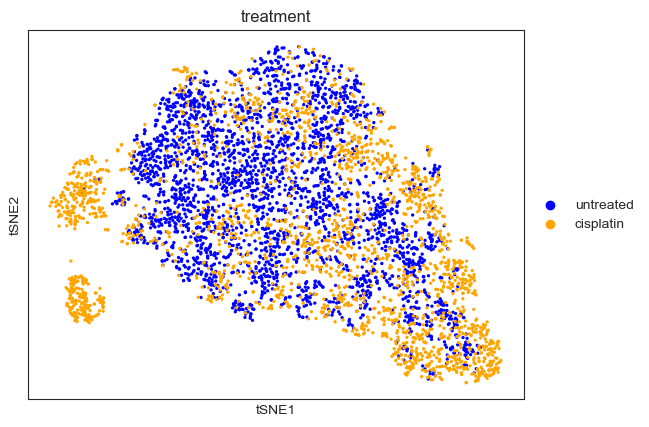

In [87]:
sc.pl.tsne(sc53, color = "treatment")

In [84]:
sc68 = sc.read_h5ad("/Users/smgroves/Dropbox (VU Basic Sciences)/Quaranta_Lab/SCLC/scRNAseq-analysis/single-cell-subtyping/subtyping_methods/code/byers_cdx/adata_mda_sc68.h5ad")


In [85]:
sc68

AnnData object with n_obs × n_vars = 4955 × 20493
    obs: 'treatment', 'n_genes_by_counts', 'total_counts', 'pct_counts_mito', 'pct_counts_ambient', 'arcsinh_total_counts', 'arcsinh_n_genes_by_counts', 'dropkick_score', 'dropkick_label', 'n_genes', 'n_counts', 'percent_mito', 'total_counts_mt', 'pct_counts_mt', 'dropkick', 'leiden', 'filtered', 'velocity_self_transition', 'nec', 'death', 'S_score', 'G2M_score', 'phase', 'clusters_gradients', 'velocity_length', 'velocity_confidence', 'velocity_confidence_transition', 'root_cells', 'end_points', 'velocity_pseudotime'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mito', 'pct_dropout_by_counts', 'ambient', 'n_cells_by_counts', 'mean_counts', 'total_counts', 'mean', 'std', 'dropkick_coef', 'mt', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'velocity_gamma_untreated', 'velocity_r2_untreated', 'velocity_genes_untreated', 'velocity_gamma_cisplatin', 'velocity_r2_cisplatin', 'velocity_genes_cisplatin', 'spear

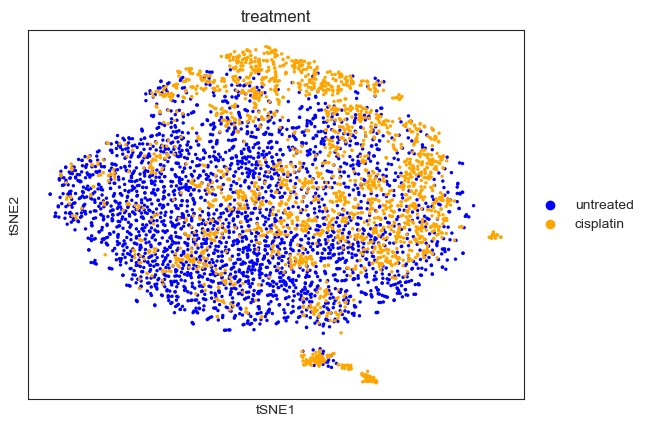

In [88]:
sc.pl.tsne(sc68, color = "treatment")